### 실습 개요
- 특정 유사도 수치를 기준으로 Video array를 분할하고 그룹화(Grouping)합니다.
- 그룹별 평균 유사도를 활용하여 해당 그룹의 활동성을 분석합니다.
- 분석 내용을 csv 파일에 저장합니다.

### 사전준비
- functions.py 안에 mp4 파일 decoding 함수들을 import 한다
- numpy를 import 한다

In [ ]:
# ../my_flask/functions.py 에 미리 정의된 함수들을 import 한다
from my_flask.functions import video_2_ndarray

# numpy를 import 한다
import numpy as np

- mp4 file로부터 video array, 재생시간, frame개수 정보를 추출하기

In [ ]:
"""
함수 video_2_ndarray 를 사용하여 ../media/SampleVideo_640x360_5mb.mp4 의 video data를 ndarray 에 저장한다.
video array, 재생시간, frame 개수를 저장
"""
video_array, tot_duration, tot_frames = video_2_ndarray('../media/SampleVideo_640x360_5mb.mp4')

- 연속되는 두 frame들간의 유사도를 구해서 차례로 list에 저장

In [ ]:
from numpy import dot
from numpy.linalg import norm

# cosine similatiry 함수
def cos_sim(A, B):
    return dot(A, B) / (norm(A) * norm(B))

In [ ]:
prev_vector = None

similarity_list = []

for frame in video_array:

    # 1차원으로 reshape
    # 255로 나눔
    # 50간격으로 sampling
    current_vector = (frame.reshape(-1) / 255)[::50]
    
    if prev_vector is not None:
        similarity = cos_sim(prev_vector, current_vector)
        similarity_list.append(similarity)
            
    prev_vector = current_vector.copy()

print('vector size : ',current_vector.shape)
print('similarity_list : ',similarity_list)

### 따라 해보기 #1. pandas를 사용하여 ndarray 정보를 csv파일에 저장하기

- 2차원 이하의 array만 pandas DataFrame으로 변환될 수 있다. video array는 4차원이므로 불가

In [ ]:
import pandas as pd

# DataFrame 생성
video_df = pd.DataFrame(video_array)

- 4차원인 video array를 (height, width) = (200, 300)를 고정하여(2차원으로 변환하여) DataFrame 생성

In [ ]:
# (height, width) = (200, 300) 번째 픽셀의 RGB 값 가져오기
the_pixel = video_array[:, 200, 300, :]
print('the_pixels의 차원 : ', the_pixel.ndim)

In [ ]:
# 첫번째 차원은 행이되고 두번째 차원은 열이됨
np_df = pd.DataFrame(the_pixel, columns=['R', 'G', 'B'])

print(np_df)

In [ ]:
np_df.plot()

- DataFrame을 csv 파일로 내려 받기

In [ ]:
csv = np_df.to_csv(path_or_buf = "the_pixel.csv", index=True)

### 따라 해보기 #2. pandas를 사용하여 영상 grouping 하기
- 유사도가 낮아지는 지점을 기준으로 grouping 하기

- 유사도 DataFrame 생성

In [ ]:
import pandas as pd

# DataFrame 생성
df = pd.DataFrame(similarity_list, columns=['similarity'])

print(df)

In [ ]:
df.plot()

- 특정 유사도 값을 기준으로 '낮은 유사도'와 '높은 유사도' 두그룹으로 분할해보기

In [ ]:
# 유사도 임계치 설정
lower_sim_threshold = 0.9

In [ ]:
# groupby 기준이 조건식이면 True와 False 두개로 grouping 된다.
dfg = df.groupby((df['similarity'] < lower_sim_threshold))

# 참고 : class 가 iterable인지 확인
# print(hasattr(dfg, '__iter__'))

# 참고 : iterable class의 첫번째 행보기
# print(next(iter(dfg)))

for group_number, group_df in dfg:
    print('Group Name : ', group_number)
    print(group_df)

- 유사도 DataFrame에 2개 칼럼 추가
	- lower_sim : 유사도 임계치 이하 여부
	- cumsum : lower_sim의 누적 합계

In [ ]:
# 출력 시 '...' 없이 전체 출력
pd.set_option('display.max_rows', None)

# 유사도가 임계치 이하면 True(1) 아니면 False(0)
df['lower_sim'] = (df['similarity'] < lower_sim_threshold)

#lower_sim의 누적합(Cumulative Sum)을 구함
df['cumsum'] = df['lower_sim'].cumsum()

# df 출력
print(df)

# 출력 시 30 rows 출력 후 '...' 처리
pd.set_option('display.max_rows', 30)

<Axes: >

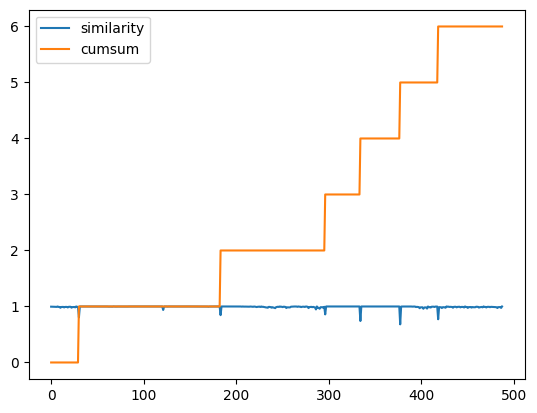

In [25]:
df.plot()

- cumsum 을 기준으로 grouping
    - 결과적으로 유사도가 낮은 순간(lower_sim_threshold 보다 작은 순간) group이 분할됨

In [26]:
df_takes = df.groupby(df['cumsum'])

for group_number, group_df in df_takes:
    print('Group Name : ', group_number)
    print(group_df)

Group Name :  0
    similarity  lower_sim  cumsum
0     0.996353      False       0
1     0.996395      False       0
2     0.995624      False       0
3     0.994776      False       0
4     0.993903      False       0
5     0.993211      False       0
6     0.992533      False       0
7     0.999972      False       0
8     0.991928      False       0
9     0.991150      False       0
10    0.977096      False       0
11    0.990728      False       0
12    0.992317      False       0
13    0.992634      False       0
14    0.983725      False       0
15    0.991934      False       0
16    0.992008      False       0
17    0.991911      False       0
18    0.982881      False       0
19    0.994120      False       0
20    0.995050      False       0
21    0.994628      False       0
22    0.978794      False       0
23    0.989008      False       0
24    0.989213      False       0
25    0.991080      False       0
26    0.984402      False       0
27    0.999991      False       

- Group별 시작 frame 번호, 종료 frame 번호, group 분할 시점의 유사도 조회

In [27]:
for group_number, group_df in df_takes:
    min_frame_number = group_df.index.min()+1
    max_frame_number = group_df.index.max()+1
    min_similarity = group_df['similarity'].min()
    print(group_number, min_frame_number, max_frame_number, min_similarity)

0 1 30 0.9770964243246925
1 31 183 0.804662909689668
2 184 296 0.8453070395907233
3 297 334 0.8589918794939202
4 335 377 0.7406269448657592
5 378 418 0.6808655525334377
6 419 488 0.7718479796650425


- Group별 유사도 평균 계산
    - 유사도 평균은 해당 Group의 영상이 얼마나 움직임이 많은지를 가늠함
    - 좁은 범위에 조밀하게 분포한 값을 넓게 분포하도록 거듭제곱 변환 (Power Transformation)사용
    - 1−x 변환을 이용해서 데이터의 범위를 [0, 1]로 유지하면서 값의 관점을 반대로 뒤집음

In [28]:
for group_number, group_df in df_takes:

    min_similarity = group_df['similarity'].min()

    # 영상의 Take가 변경되는 지점의 similarity는 빼고 해당 Take(group DataFrame)의 similarity 평균을 구함
    similarity_mean = group_df[group_df['similarity'] > min_similarity]['similarity'].mean()

    # 1. 거듭제곱 변환 (Power Transformation)
    # 좁은 범위에 조밀하게 분포한 값을 넓게 분포하도록 변환(20 거듭제곱)
    # - data들이 0~1 사이 값이므로 거듭제곱 할수록 1에서 멀어지고 0 에 가까와짐. 
    # - data들이 1 근처에 조밀하게 분포하는 경우 효과적으로 분산시킴
    # 2. 1−x 변환
    # 데이터의 범위를 [0, 1]로 유지하면서 값의 관점을 반대로 뒤집음
    # - 값이 클수록 동적인 영상, 작을수록 정적인 영상이됨
    similarity_mean_power = similarity_mean**20
    activity_intensity = 1 - similarity_mean_power
    
    print(similarity_mean, similarity_mean_power, activity_intensity)

0.9919528601367872 0.8507866754367176 0.1492133245632824
0.9990438849814886 0.9810503968891635 0.018949603110836488
0.9923539087293849 0.8576926591372993 0.1423073408627007
0.9999834293699692 0.9996686395654955 0.0003313604345045462
0.9998346260059869 0.996697711193437 0.003302288806563025
0.9917612768364581 0.8475063220058854 0.15249367799411462
0.9892107511652373 0.8049641819961638 0.19503581800383618


- Group별 frame개수, 시작시간, 재생시간 계산
    - 사전준비 단계에서 구했던 tot_duration(재생시간), tot_frames(frame 개수) 사용하여 frame개수, 시작시간, 재생시간 항목 생성

In [29]:
for group_number, group_df in df_takes:

    min_frame_number = group_df.index.min()+1
    max_frame_number = group_df.index.max()+1

    frame_count = max_frame_number - min_frame_number + 1
    start = tot_duration*(min_frame_number/tot_frames)
    duration = tot_duration*(frame_count/tot_frames)

    print(frame_count, start, duration)

30 0.05 1.5
153 1.55 7.65
113 9.2 5.65
38 14.850000000000001 1.9000000000000001
43 16.75 2.15
41 18.9 2.05
70 20.95 3.5


- Group DataFrame 생성

In [30]:
# 사전준비 단계에 구했던 tot_duration(재생시간), tot_frames(frame 개수) 사용

groups = []

for group_number, group_df in df_takes:

    min_frame_number = group_df.index.min()+1
    max_frame_number = group_df.index.max()+1
    min_similarity = group_df['similarity'].min()

    activity_intensity = 1 - group_df[group_df['similarity'] >\
                                min_similarity]['similarity'].mean()**20

    frame_count = max_frame_number - min_frame_number + 1
    start = tot_duration*(min_frame_number/tot_frames)
    duration = tot_duration*(frame_count/tot_frames)

    # dictionary를 append하는 경우 key값이 column명이 됨
    groups.append({
        'group_number': group_number,
        'group_name': f"Take #{group_number}",
        'min_frame_number': min_frame_number,
        'max_frame_number': max_frame_number,
        'frame_count' : frame_count,
        'start' : "{:.2f}".format(start),
        'duration' : "{:.2f}".format(duration),
        'min_similarity': min_similarity,
        'activity_intensity':activity_intensity
    })

# group 정보로 DataFrame 생성
group_df = pd.DataFrame(groups)

print(group_df)

   group_number group_name  min_frame_number  max_frame_number  frame_count  \
0             0    Take #0                 1                30           30   
1             1    Take #1                31               183          153   
2             2    Take #2               184               296          113   
3             3    Take #3               297               334           38   
4             4    Take #4               335               377           43   
5             5    Take #5               378               418           41   
6             6    Take #6               419               488           70   

   start duration  min_similarity  activity_intensity  
0   0.05     1.50        0.977096            0.149213  
1   1.55     7.65        0.804663            0.018950  
2   9.20     5.65        0.845307            0.142307  
3  14.85     1.90        0.858992            0.000331  
4  16.75     2.15        0.740627            0.003302  
5  18.90     2.05        0.6808

- DataFrame을 csv파일에 저장

In [31]:
csv = group_df.to_csv(path_or_buf = "video_grouping.csv", 
                      columns=[
                          'group_name', 
                          'frame_count', 
                          'start', 
                          'duration', 
                          'min_frame_number', 
                          'max_frame_number', 
                          'activity_intensity',
                          'min_similarity', 
                          ], 
                      index=False)